### Importing necessary libraries

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
from plotly import __version__
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
import cufflinks as cf
import plotly.graph_objs as go
import plotly.io as pio
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import plotly.figure_factory as ff
from sklearn.inspection import permutation_importance

init_notebook_mode(connected=True)
cf.go_offline()

In [3]:
from scipy.stats import spearmanr

### Reading the data into a DataFrame called dengue_features_train
This dataset encompasses observations from two distinct urban areas: **San Juan**, Puerto Rico (on the right) and **Iquitos**, Peru (on the left). Recognizing the potential variance in dengue spread dynamics between these locales, our approach involves leveraging the dataset as a whole. We'll develop individual models for each city and later integrate their predictions to formulate our conclusive submission.

In [4]:
dengue_features_train, dengue_features_test, dengue_labels_train = tuple([pd.read_csv(filepath_or_buffer=data, index_col=[1,2,0]) for data in ['dengue_features_train.csv','dengue_features_test.csv','dengue_labels_train.csv']])

### Display the first few rows of the training features data
The problem description provides a comprehensive overview of the available variables. However, we'll also examine the initial entries of the dataset here.

In [5]:
dengue_features_train.head()

week_start_date   ndvi_ne   ndvi_nw   ndvi_se   ndvi_sw  \
year weekofyear city                                                           
1990 18         sj        1990-04-30  0.122600  0.103725  0.198483  0.177617   
     19         sj        1990-05-07  0.169900  0.142175  0.162357  0.155486   
     20         sj        1990-05-14  0.032250  0.172967  0.157200  0.170843   
     21         sj        1990-05-21  0.128633  0.245067  0.227557  0.235886   
     22         sj        1990-05-28  0.196200  0.262200  0.251200  0.247340   

                      precipitation_amt_mm  reanalysis_air_temp_k  \
year weekofyear city                                                
1990 18         sj                   12.42             297.572857   
     19         sj                   22.82             298.211429   
     20         sj                   34.54             298.781429   
     21         sj                   15.36             298.987143   
     22         sj                    7.52             299.518571   

                      reanalysis_avg_temp_k  reanalysis_dew_point_temp_k  \
year weekofyear city                                                       
1990 18         sj               297.742857                   292.414286   
     19         sj               298.442857                   293.951429   
     20         sj               298.878571                   295.434286   
     21         sj               299.228571                   295.310000   
     22         sj               299.664286                   295.821429   

                      reanalysis_max_air_temp_k  ...  \
year weekofyear city                             ...   
1990 18         sj                        299.8  ...   
     19         sj                        300.9  ...   
     20         sj                        300.5  ...   
     21         sj                        301.4  ...   
     22         sj                        301.9  ...   

                      reanalysis_precip_amt_kg_per_m2  \
year weekofyear city                                    
1990 18         sj                              32.00   
     19         sj                              17.94   
     20         sj                              26.10   
     21         sj                              13.90   
     22         sj                              12.20   

                      reanalysis_relative_humidity_percent  \
year weekofyear city                                         
1990 18         sj                               73.365714   
     19         sj                               77.368571   
     20         sj                               82.052857   
     21         sj                               80.337143   
     22         sj                               80.460000   

                      reanalysis_sat_precip_amt_mm  \
year weekofyear city                                 
1990 18         sj                           12.42   
     19         sj                           22.82   
     20         sj                           34.54   
     21         sj                           15.36   
     22         sj                            7.52   

                      reanalysis_specific_humidity_g_per_kg  \
year weekofyear city                                          
1990 18         sj                                14.012857   
     19         sj                                15.372857   
     20         sj                                16.848571   
     21         sj                                16.672857   
     22         sj                                17.210000   

                      reanalysis_tdtr_k  station_avg_temp_c  \
year weekofyear city                                          
1990 18         sj             2.628571           25.442857   
     19         sj             2.371429           26.714286   
     20         sj             2.300000           26.714286   
     21         sj             2.428571           27.471429   
     22         

### Display the first few rows of the training labels data
Next, let's check the initial entries of the labels data.

In [6]:
dengue_labels_train.head()

total_cases
year weekofyear city             
1990 18         sj              4
     19         sj              5
     20         sj              4
     21         sj              3
     22         sj              6

### Check the shape of the training features data

In [7]:
dengue_features_train.shape

(1456, 21)

### Display information about the training features data
Let's check the detailed summary of the dataset, including information such as the data types of each variable, the **number of non-null entries**, and **memory usage**.

In [8]:
dengue_features_train.info()

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 1456 entries, (1990, 18, 'sj') to (2010, 25, 'iq')
Data columns (total 21 columns):
 #   Column                                 Non-Null Count  Dtype  
---  ------                                 --------------  -----  
 0   week_start_date                        1456 non-null   object 
 1   ndvi_ne                                1262 non-null   float64
 2   ndvi_nw                                1404 non-null   float64
 3   ndvi_se                                1434 non-null   float64
 4   ndvi_sw                                1434 non-null   float64
 5   precipitation_amt_mm                   1443 non-null   float64
 6   reanalysis_air_temp_k                  1446 non-null   float64
 7   reanalysis_avg_temp_k                  1446 non-null   float64
 8   reanalysis_dew_point_temp_k            1446 non-null   float64
 9   reanalysis_max_air_temp_k              1446 non-null   float64
 10  reanalysis_min_air_temp_k              1446 n

If we observe in the above information certain columns with **missing values** in the features dataset, it underscores the need to address these gaps in the data to maintain the integrity of our analysis and modeling endeavors.

### Check for missing values in the training features data
Let's delve into the dataset to ascertain the presence of missing values within each column, shedding light on the completeness of our data and informing any necessary preprocessing steps.

In [9]:
dengue_features_train.isnull().sum()

week_start_date                            0
ndvi_ne                                  194
ndvi_nw                                   52
ndvi_se                                   22
ndvi_sw                                   22
precipitation_amt_mm                      13
reanalysis_air_temp_k                     10
reanalysis_avg_temp_k                     10
reanalysis_dew_point_temp_k               10
reanalysis_max_air_temp_k                 10
reanalysis_min_air_temp_k                 10
reanalysis_precip_amt_kg_per_m2           10
reanalysis_relative_humidity_percent      10
reanalysis_sat_precip_amt_mm              13
reanalysis_specific_humidity_g_per_kg     10
reanalysis_tdtr_k                         10
station_avg_temp_c                        43
station_diur_temp_rng_c                   43
station_max_temp_c                        20
station_min_temp_c                        14
station_precip_mm                         22
dtype: int64

### Check for missing values in the training labels data
Let's conduct a similar analysis for the labels dataset to assess the presence of missing values within each column, ensuring a comprehensive understanding of our target variables.

In [10]:
dengue_labels_train.isnull().sum()

total_cases    0
dtype: int64

Indeed, it appears that the column **"ndvi_ne"** has the highest number of missing values among the variables and there are no missing values in labels data. This observation highlights the importance of handling missing data effectively to ensure the robustness of our analysis and modeling process.

### Plotting the graph for the missing values

In [11]:
missing_data_columns = dengue_features_train[['ndvi_ne', 'ndvi_nw', 'ndvi_se', 'ndvi_sw', 'precipitation_amt_mm', 'reanalysis_air_temp_k', 'reanalysis_avg_temp_k', 'reanalysis_dew_point_temp_k', 'reanalysis_max_air_temp_k', 'reanalysis_min_air_temp_k', 'reanalysis_precip_amt_kg_per_m2', 'reanalysis_relative_humidity_percent', 'reanalysis_sat_precip_amt_mm', 'reanalysis_specific_humidity_g_per_kg', 'reanalysis_tdtr_k', 'station_avg_temp_c', 'station_diur_temp_rng_c', 'station_max_temp_c', 'station_min_temp_c', 'station_precip_mm']]

We'll create a line plot to visualize the distribution of missing values across the columns specified in the variable **`missing_data_columns`**.

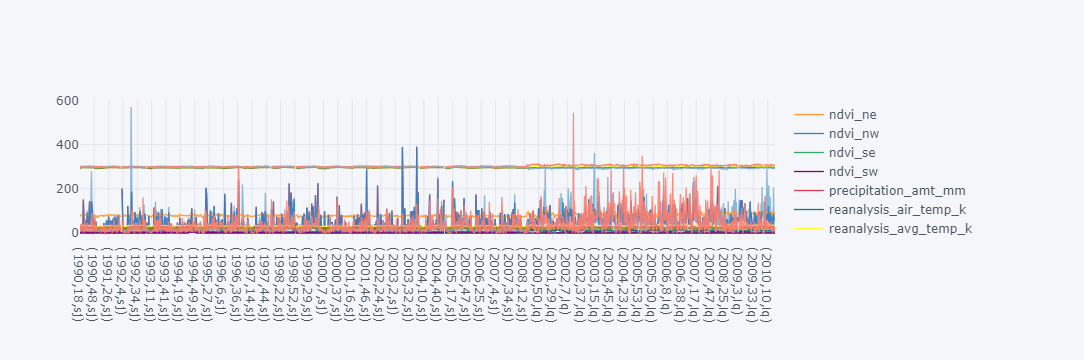

In [12]:
missing_data_columns.iplot(kind='line')

The interactive plot above allows for zooming in to observe the distribution of missing values across the specified columns.

Let's visualize the count of missing values using a bar plot and heatmap.

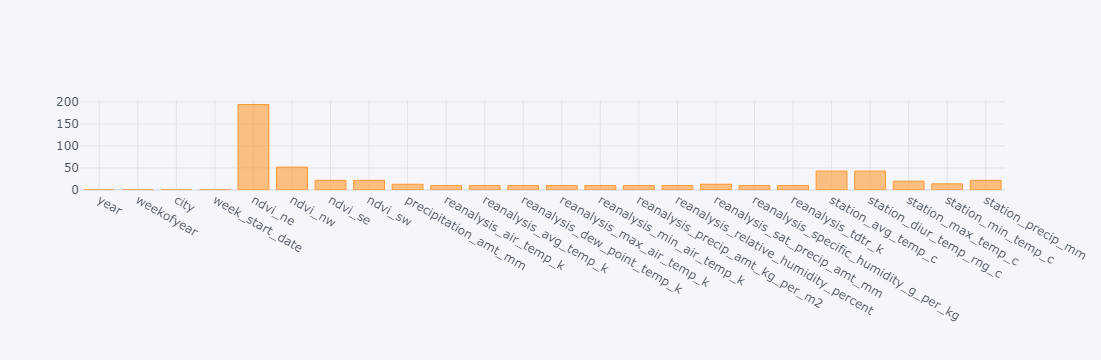

In [13]:
dengue_features_train.reset_index().isnull().sum().iplot(kind='bar')

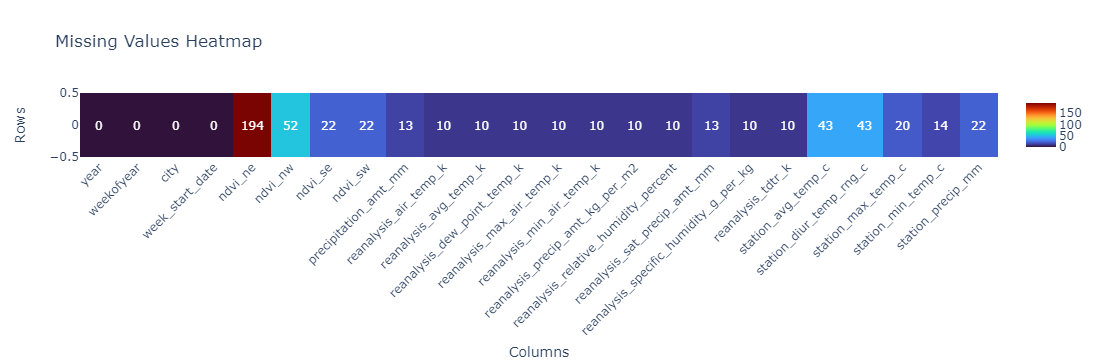

In [14]:
# Calculate missing values count for each column
missing_values_count = dengue_features_train.reset_index().isnull().sum().values

# Extract the column name for those missing values
column_names = dengue_features_train.reset_index().columns

# Creating annotations for heatmap
annotations = []
for i, col in enumerate(column_names):
    annotations.append(dict(x=i, y=0, text=str(missing_values_count[i]),
                            font=dict(color='white'), showarrow=False))

# Create heatmap
heatmap_data = [go.Heatmap(z=[missing_values_count], colorscale='turbo')]

# Set layout options
layout = go.Layout(title='Missing Values Heatmap',
                   xaxis=dict(title='Columns', tickvals=list(range(len(column_names))),
                              ticktext=column_names, tickangle=-45),
                   yaxis=dict(title='Rows'),
                   annotations=annotations)

# Create the figure
fig = go.Figure(data=heatmap_data, layout=layout)

# Show the plot
pio.show(fig)

The interactive plot above underscores a significant number of missing values, notably in the **`ndvi_ne`** column. As these values are crucial for model building, we'll adopt a straightforward strategy: removing a few rows with missing values and imputing the rest by filling them with the most recent observed value up to that point.

### Display all rows whose values are missing
Let's extract all the column names which has missing values and diplay only these columns which has missing value.

In [15]:
# Extract rows with missing values in any of the specified columns and display these columns
dengue_features_train[dengue_features_train[dengue_features_train.columns[dengue_features_train.isnull().any()].tolist()].isnull().any(axis=1)]

week_start_date   ndvi_ne   ndvi_nw   ndvi_se   ndvi_sw  \
year weekofyear city                                                           
1990 23         sj        1990-06-04       NaN  0.174850  0.254314  0.181743   
     27         sj        1990-07-02       NaN  0.121550  0.160683  0.202567   
     31         sj        1990-07-30       NaN  0.247150  0.379700  0.381357   
     32         sj        1990-08-06       NaN  0.064333  0.164443  0.138857   
     33         sj        1990-08-13       NaN  0.128033  0.206957  0.168243   
...                              ...       ...       ...       ...       ...   
2009 23         iq        2009-06-04  0.114000  0.092443  0.097471  0.126286   
     32         iq        2009-08-06  0.395000  0.352733  0.484286  0.401914   
2010 53         iq        2010-01-01       NaN       NaN       NaN       NaN   
     1          iq        2010-01-08  0.124571  0.179129  0.163843  0.135471   
     14         iq        2010-04-09  0.242843  0.272757  0.202271  0.260114   

                      precipitation_amt_mm  reanalysis_air_temp_k  \
year weekofyear city                                                
1990 23         sj                    9.58             299.630000   
     27         sj                   14.41             300.154286   
     31         sj                   32.66             299.862857   
     32         sj                   28.80             300.391429   
     33         sj                   90.75             299.958571   
...                                    ...                    ...   
2009 23         iq                   42.22             296.125714   
     32         iq                    9.79             297.370000   
2010 53         iq                     NaN                    NaN   
     1          iq                   27.04             299.264286   
     14         iq                   93.76             299.115714   

                      reanalysis_avg_temp_k  reanalysis_dew_point_temp_k  \
year weekofyear city                                                       
1990 23         sj               299.764286                   295.851429   
     27         sj               300.278571                   296.651429   
     31         sj               299.950000                   296.172857   
     32         sj               300.478571                   296.532857   
     33         sj               299.957143                   297.035714   
...                                     ...                          ...   
2009 23         iq               296.778571                   295.267143   
     32         iq               298.878571                   294.824286   
2010 53         iq                      NaN                          NaN   
     1          iq               300.521429                   294.530000   
     14         iq               300.271429                   298.161429   

                      reanalysis_max_air_temp_k  ...  \
year weekofyear city                             ...   
1990 23         sj                        302.4  ...   
     27         sj                        302.3  ...   
     31         sj                        303.0  ...   
     32         sj                        302.5  ...   
     33         sj                        302.6  ...   
...                                         ...  ...   
2009 23         iq                        302.5  ...   
     32         iq                        307.9  ...   
2010 53         iq                          NaN  ...   
     1          iq                        308.6  ...   
     14         iq                        308.4  ...   

                      reanalysis_precip_amt_kg_per_m2  \
year weekofyear city                                    
1990 23         sj                              26.49   
     27         sj                              28.40   
     31         sj                              34.60   
     32         sj                              20.00   
     33         sj    

### Extract rows from the dataset that contain a specified number of missing values.
Next, let's showcase rows that exhibit over **3** missing values, pinpointing instances where data completeness may be a concern.

In [16]:
# Define the threshold for the number of missing values
threshold = 3

# Count the number of missing values in each row
missing_values_count = dengue_features_train.isnull().sum(axis=1)

# Filter rows with more than the specified number of missing values
rows_with_missing_values = dengue_features_train[missing_values_count > threshold]
(rows_with_missing_values.shape)[0]

30

### Drop rows with more than the specified number (i.e. 3) of missing values
Since there are 30 rows with more than 3 NaN values within them, one approach to rectify this issue is to drop these rows.

In [17]:
threshold = 3

# Filter rows with more than the specified number of missing values
dengue_features_train.dropna(thresh=dengue_features_train.shape[1]-threshold,inplace=True)
dengue_labels_train.drop(index=rows_with_missing_values.index,inplace=True)

### Extract rows with remaining missing values

In [18]:
dengue_features_train[dengue_features_train[dengue_features_train.columns[dengue_features_train.isnull().any()].tolist()].isnull().any(axis=1)].shape

(227, 21)

### Fixing the columns with remaining missing values
This code utilizes the **`KNNImputer`** to address missing values in the DataFrame by replacing them with estimates derived from the nearest neighbors, subsequently updating the original DataFrame while ensuring existing data remains unchanged.

In [19]:
from sklearn.impute import KNNImputer

# Drop the 'week_start_date' column
dengue_features_train_numeric = dengue_features_train.drop('week_start_date', axis=1)

# Initialize KNNImputer
imputer = KNNImputer(n_neighbors=20)

# Impute missing values using KNN
dengue_features_train_imputed = imputer.fit_transform(dengue_features_train_numeric)

# Convert the imputed array back to a DataFrame
dengue_features_train_imputed = pd.DataFrame(dengue_features_train_imputed, columns=dengue_features_train_numeric.columns)
dengue_features_train_imputed.index = dengue_features_train.index

# Update the original DataFrame with the imputed values
null_mask = dengue_features_train.isnull()
dengue_features_train = dengue_features_train.where(~null_mask, dengue_features_train_imputed)

# Check if there are any remaining missing values
dengue_features_train.isnull().any()

week_start_date                          False
ndvi_ne                                  False
ndvi_nw                                  False
ndvi_se                                  False
ndvi_sw                                  False
precipitation_amt_mm                     False
reanalysis_air_temp_k                    False
reanalysis_avg_temp_k                    False
reanalysis_dew_point_temp_k              False
reanalysis_max_air_temp_k                False
reanalysis_min_air_temp_k                False
reanalysis_precip_amt_kg_per_m2          False
reanalysis_relative_humidity_percent     False
reanalysis_sat_precip_amt_mm             False
reanalysis_specific_humidity_g_per_kg    False
reanalysis_tdtr_k                        False
station_avg_temp_c                       False
station_diur_temp_rng_c                  False
station_max_temp_c                       False
station_min_temp_c                       False
station_precip_mm                        False
dtype: bool

Now that we've addressed all missing values, let's visualize the dataset using a bar plot to gain insights into its structure. Following that, we'll proceed to correlate the data to uncover any relationships between variables.

### Plot to check missing values using bar plot

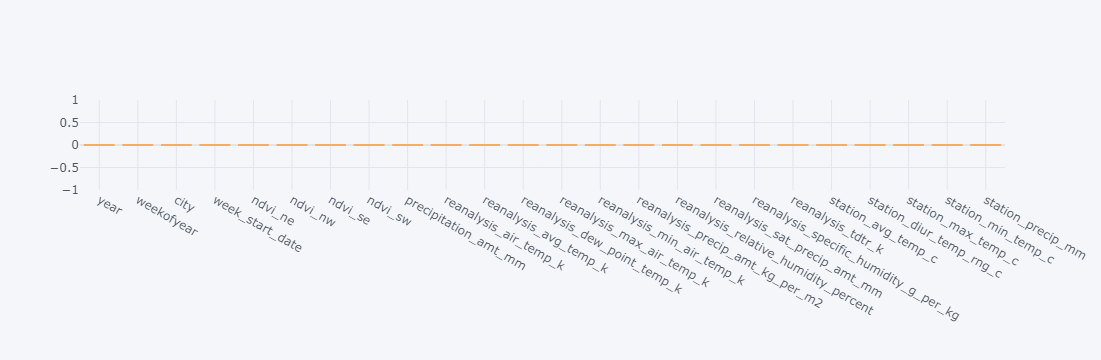

In [20]:
dengue_features_train.reset_index().isnull().sum().iplot(kind='bar')

Given the absence of missing data, we can confidently proceed with feature selection by correlating the variables with the target data. This step will help identify the most influential features for our modeling process.

### Display summary statistics of the training features data

In [21]:
dengue_features_train.describe()

,ndvi_ne,ndvi_nw,ndvi_se,ndvi_sw,precipitation_amt_mm,reanalysis_air_temp_k,reanalysis_avg_temp_k,reanalysis_dew_point_temp_k,reanalysis_max_air_temp_k,reanalysis_min_air_temp_k,reanalysis_precip_amt_kg_per_m2,reanalysis_relative_humidity_percent,reanalysis_sat_precip_amt_mm,reanalysis_specific_humidity_g_per_kg,reanalysis_tdtr_k,station_avg_temp_c,station_diur_temp_rng_c,station_max_temp_c,station_min_temp_c,station_precip_mm
count,1426.000000,1426.000000,1426.000000,1426.000000,1426.000000,1426.000000,1426.000000,1426.000000,1426.000000,1426.000000,1426.000000,1426.000000,1426.000000,1426.000000,1426.000000,1426.000000,1426.000000,1426.000000,1426.000000,1426.000000
mean,0.135051,0.129720,0.203668,0.202229,45.812268,298.698707,299.225957,295.242379,303.443969,295.705610,40.187349,82.163589,45.812268,16.743127,4.927189,27.187091,8.093377,32.453380,22.094414,39.426034
std,0.133963,0.118882,0.073882,0.083779,43.725213,1.367775,1.267664,1.534522,3.246058,2.574059,43.618605,7.163580,43.725213,1.548791,3.557163,1.284644,2.123640,1.960135,1.576234,47.513642
min,-0.406250,-0.456100,-0.015533,-0.063457,0.000000,294.635714,294.892857,289.642857,297.800000,286.900000,0.000000,57.787143,0.000000,11.715714,1.357143,21.400000,4.528571,26.700000,14.700000,0.000000
25%,0.047170,0.049542,0.155087,0.144209,9.815000,297.648571,298.251786,294.110000,301.000000,293.900000,13.010000,77.177143,9.815000,15.529643,2.328571,26.303571,6.528571,31.100000,21.100000,8.700000
50%,0.114300,0.118705,0.195950,0.189536,38.390000,298.640714,299.292857,295.639286,302.500000,296.200000,27.200000,80.305714,38.390000,17.084286,2.864286,27.428571,7.350000,32.800000,22.200000,23.900000
75%,0.231796,0.213868,0.248846,0.246982,70.280000,299.838571,300.214286,296.468571,305.500000,297.900000,52.425000,86.495357,70.280000,17.982857,7.685714,28.128571,9.600000,33.900000,23.300000,54.100000
max,0.508357,0.454429,0.538314,0.546017,390.600000,302.200000,302.928571,298.450000,314.000000,299.900000,570.500000,98.610000,390.600000,20.461429,16.028571,30.800000,15.800000,42.200000,25.600000,543.300000


In [22]:
dengue_combined_train = pd.merge(dengue_features_train.reset_index(), dengue_labels_train.reset_index(), on=["city", "year", "weekofyear"])

Let's remove the **`week_start_date`** column from consideration during feature selection as it won't be utilized in the process.

In [23]:
dengue_features_train.drop('week_start_date',axis=1, inplace=True)
dengue_combined_train.drop('week_start_date',axis=1, inplace=True)

### Feature selection and Model Training
Now, let's create a heatmap to visualize the correlations within the dataset.

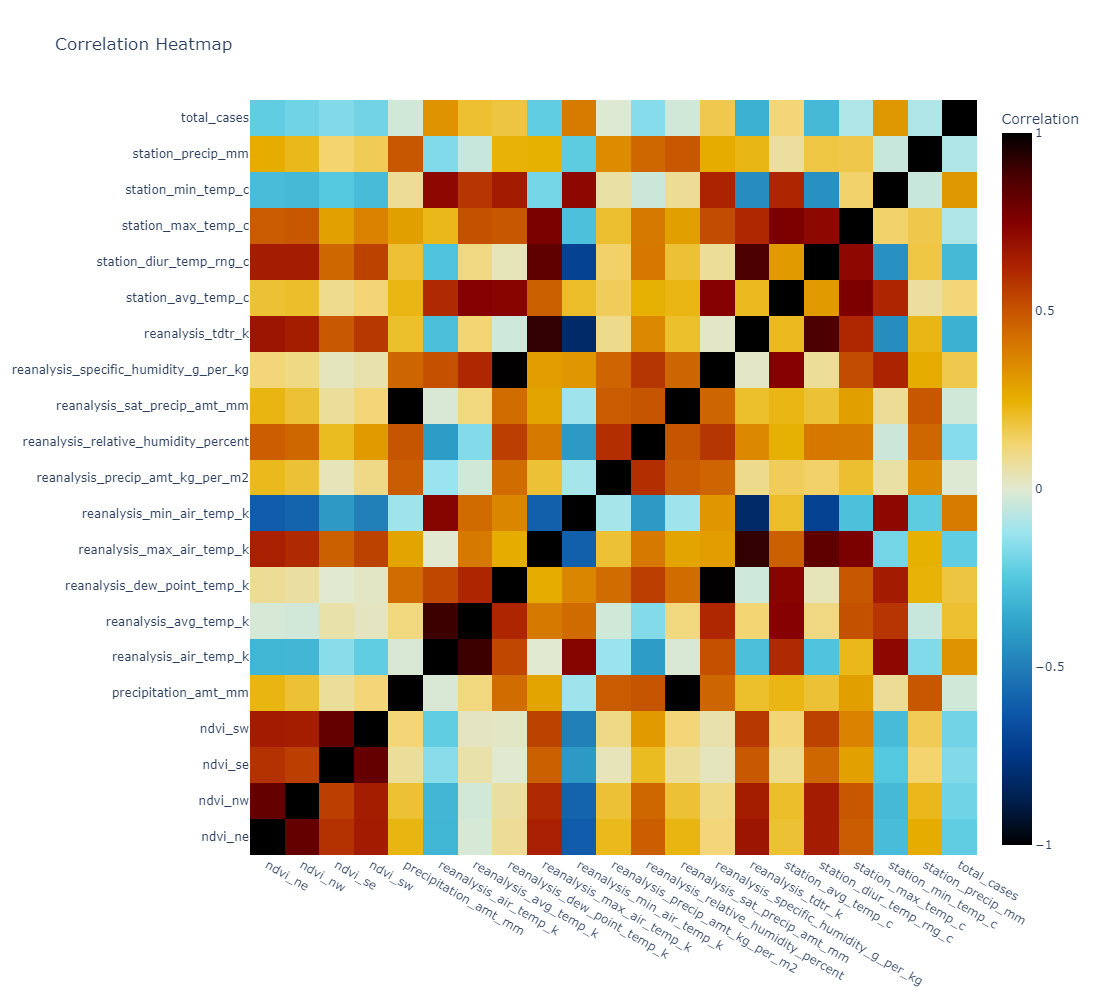

In [24]:
# Creating a correlation of the matrix
corr_matrix = dengue_combined_train.drop(columns=["city", "year", "weekofyear"]).corr()

# Create heatmap
heatmap_trace = go.Heatmap(
    z=corr_matrix.values,
    x=corr_matrix.columns,
    y=corr_matrix.index,
    colorscale='icefire',
    colorbar=dict(title='Correlation'),
    zmin=-1, zmax=1,
    )

# Set layout options
layout = go.Layout(
    title='Correlation Heatmap',
    width=1000,
    height=1000,
    )

# Create the figure
fig = go.Figure(data=[heatmap_trace], layout=layout)

# Show the plot
fig.iplot()

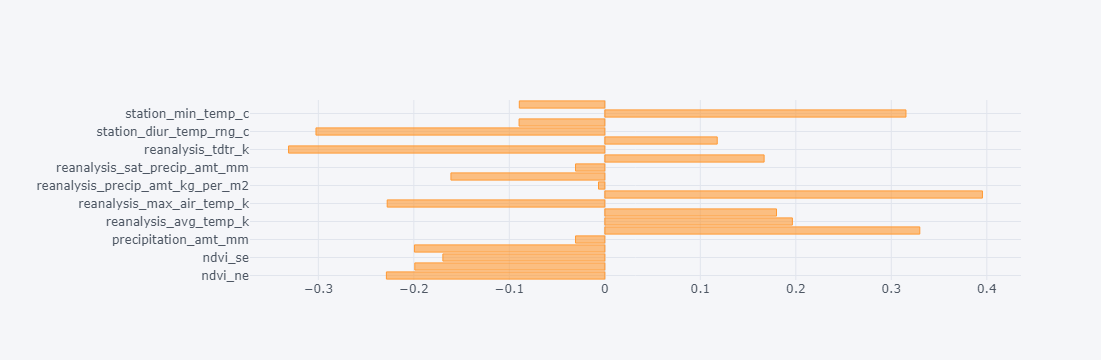

In [25]:
corr_matrix.total_cases.drop('total_cases').iplot(kind='barh')

We've identified several columns with a correlation coefficient greater than 0 with the `total_cases` variable based on the heatmap analysis. These columns are: `reanalysis_air_temp_k`, `reanalysis_avg_temp_k`, `reanalysis_dew_point_temp_k`, `reanalysis_min_air_temp_k`, `reanalysis_specific_humidity_g_per_kg`, `station_avg_temp_c`, and `station_min_temp_c`. However, we'll explore alternative methods for feature selection.

### Import necessary libaries for model

In [26]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.svm import SVR
from sklearn.metrics import mean_absolute_error, mean_squared_error, explained_variance_score
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler

### Selecting all Features for Training set
We're constructing models for **`Random Forest`**, **`Linear Regression`**, and **`Support Vector Machine`** using all available features. After training these models, we'll assess their performance on the training set by calculating **`Mean Absolute Error (MAE)`** and **`Root Mean Squared Error (RMSE)`**. Finally, we'll utilize these models to predict values.

In [27]:
# Separate features (X) and labels (y)
X = dengue_combined_train.drop(columns=["city", "total_cases"])
y = dengue_combined_train["total_cases"]

# Split the training data into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)
X_train_info = dengue_combined_train.loc[y_train.index, ["year", "weekofyear", "city"]]

# Train Random Forest model
rf_model = RandomForestRegressor(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)

# Train Linear Regression model
lr_model = LinearRegression()
lr_model.fit(X_train, y_train)

# Train Support Vector Machine (SVM) model
svm_model = SVR()
svm_model.fit(X_train, y_train)

SVR()

Now, let's proceed with predicting the values for the training set.

In [28]:
# Make predictions on the training set and round off to nearest integer
train_predictions_rf = np.round(rf_model.predict(X_train)).astype(int)
train_predictions_lr = np.round(lr_model.predict(X_train)).astype(int)
train_predictions_svm = np.round(svm_model.predict(X_train)).astype(int)

We are computing the `Mean Absolute Error (MAE)` and `Root Mean Squared Error (RMSE)` for the training set.

In [29]:
# Calculate MAE and RMSE for training set predictions
rf_mae_train = mean_absolute_error(y_train, train_predictions_rf)
rf_rmse_train = mean_squared_error(y_train, train_predictions_rf, squared=False)

lr_mae_train = mean_absolute_error(y_train, train_predictions_lr)
lr_rmse_train = mean_squared_error(y_train, train_predictions_lr, squared=False)

svm_mae_train = mean_absolute_error(y_train, train_predictions_svm)
svm_rmse_train = mean_squared_error(y_train, train_predictions_svm, squared=False)

D:\Software\Python 3.12\Lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning:

'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.

D:\Software\Python 3.12\Lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning:

'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.

D:\Software\Python 3.12\Lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning:

'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.



In [30]:
# Print results
print("Random Forest:")
print(f"Training MAE: {rf_mae_train:.2f}, Training RMSE: {rf_rmse_train:.2f}")

print("\nLinear Regression:")
print(f"Training MAE: {lr_mae_train:.2f}, Training RMSE: {lr_rmse_train:.2f}")

print("\nSupport Vector Machine:")
print(f"Training MAE: {svm_mae_train:.2f}, Training RMSE: {svm_rmse_train:.2f}")


Random Forest:
Training MAE: 4.32, Training RMSE: 8.20

Linear Regression:
Training MAE: 15.79, Training RMSE: 26.78

Support Vector Machine:
Training MAE: 17.02, Training RMSE: 32.17


As observed, the **`Random Forest`** model has achieved the lowest MAE and RMSE on the training set, with `MAE:` **`4.32`** and `RMSE:` **`8.20`**, outperforming both the **`Linear Regression`** and **`SVM`** models.

We will store these computed metrics in a DataFrame, facilitating their easy exportation in the required competition format.

In [31]:
rf_predictions_df = pd.DataFrame({
    "city": X_train_info["city"],
    "year": X_train_info["year"],
    "weekofyear": X_train_info["weekofyear"],
    "total_cases_predicted": train_predictions_rf
})
lr_predictions_df = pd.DataFrame({
    "city": X_train_info["city"],
    "year": X_train_info["year"],
    "weekofyear": X_train_info["weekofyear"],
    "total_cases_predicted": train_predictions_lr
})
svm_predictions_df = pd.DataFrame({
    "city": X_train_info["city"],
    "year": X_train_info["year"],
    "weekofyear": X_train_info["weekofyear"],
    "total_cases_predicted": train_predictions_svm
})

### Selecting all Features for Validation set
Let's repeat the same steps for the `training set` and then complete the `validation set`.

In [32]:
# Separate features (X) and labels (y)
X = dengue_combined_train.drop(columns=["city","total_cases"])
y = dengue_combined_train["total_cases"]

# Split the data into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)
X_val_info = dengue_combined_train.loc[y_val.index, ["city", "year", "weekofyear"]]

# Standardize features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)

# Train Random Forest model
rf_model = RandomForestRegressor(random_state=42)
rf_model.fit(X_train_scaled, y_train)

# Train Linear Regression model
lr_model = LinearRegression()
lr_model.fit(X_train_scaled, y_train)

# Train SVM model
svm_model = SVR()
svm_model.fit(X_train_scaled, y_train)

SVR()

Now, let's proceed with predicting the values for the validation set.

In [33]:
# Make predictions on validation set
rf_predictions_val = np.round(rf_model.predict(X_val_scaled)).astype(int)
lr_predictions_val = np.round(lr_model.predict(X_val_scaled)).astype(int)
svm_predictions_val = np.round(svm_model.predict(X_val_scaled)).astype(int)

We are computing the `Mean Absolute Error (MAE)` and `Root Mean Squared Error (RMSE)` for the  validation set.

In [34]:
# Evaluate models on validation set
rf_mae_val = mean_absolute_error(y_val, rf_predictions_val)
rf_rmse_val = mean_squared_error(y_val, rf_predictions_val, squared=False)

lr_mae_val = mean_absolute_error(y_val, lr_predictions_val)
lr_rmse_val = mean_squared_error(y_val, lr_predictions_val, squared=False)

svm_mae_val = mean_absolute_error(y_val, svm_predictions_val)
svm_rmse_val = mean_squared_error(y_val, svm_predictions_val, squared=False)

D:\Software\Python 3.12\Lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning:

'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.

D:\Software\Python 3.12\Lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning:

'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.

D:\Software\Python 3.12\Lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning:

'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.



In [35]:
print("Validation Set Evaluation:")
print("Random Forest Model:")
print("MAE:", rf_mae_val)
print("RMSE:", rf_rmse_val)

print("\nLinear Regression Model:")
print("MAE:", lr_mae_val)
print("RMSE:", lr_rmse_val)

print("\nSVM Model:")
print("MAE:", svm_mae_val)
print("RMSE:", svm_rmse_val)

print("\nResiduals \nMAE:", abs(rf_mae_val-rf_mae_train), '\nRMSE:', abs(rf_rmse_train-rf_rmse_val))


Validation Set Evaluation:
Random Forest Model:
MAE: 10.853146853146853
RMSE: 19.89465261815855

Linear Regression Model:
MAE: 16.402097902097903
RMSE: 26.91277025497752

SVM Model:
MAE: 13.576923076923077
RMSE: 28.477632002600295

Residuals 
MAE: 6.528585449638081 
RMSE: 11.69837618502008


Upon observation, the **`Random Forest`** model has demonstrated the lowest `MAE` and `RMSE` on the training set, with `MAE: 10.85` and `RMSE: 19.89`, surpassing both the **`Linear Regression`** and **`SVM`** models. However, the **residuals** for `MAE (6.52)` and `RMSE (11.69)` are relatively high. Therefore, we'll employ different techniques to mitigate these residuals.

We will store these computed metrics in a DataFrame, facilitating their easy exportation in the required competition format.

In [36]:
rf_predictions_df = pd.DataFrame({
    "city": X_val_info["city"],
    "year": X_val_info["year"],
    "weekofyear": X_val_info["weekofyear"],
    "total_cases_predicted": rf_predictions_val
})
lr_predictions_df = pd.DataFrame({
    "city": X_val_info["city"],
    "year": X_val_info["year"],
    "weekofyear": X_val_info["weekofyear"],
    "total_cases_predicted": lr_predictions_val
})
svm_predictions_df = pd.DataFrame({
    "city": X_val_info["city"],
    "year": X_val_info["year"],
    "weekofyear": X_val_info["weekofyear"],
    "total_cases_predicted": svm_predictions_val
})

We will store these computed metrics in a DataFrame, facilitating their easy exportation in the required competition format.

Now, let's generates a subplot with four panels, each representing different aspects of the model evaluation: overall `validation results`, and `predictions` **versus** `actual values` for **`Random Forest`**, **`Linear Regression`**, and **`Support Vector Machine`** models. Each subplot contains scatter plots with `actual versus predicted values`.

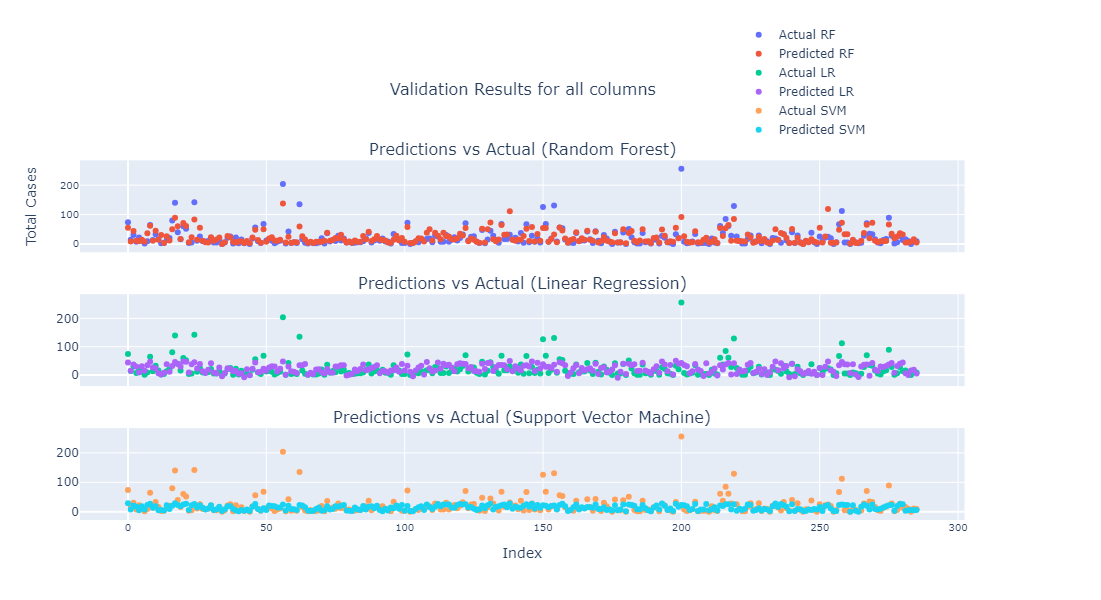

In [37]:
fig = make_subplots(rows=4, cols=1, subplot_titles=("Validation Results for all columns",
                  
                                                    "Predictions vs Actual (Random Forest)", 
                                                    "Predictions vs Actual (Linear Regression)", 
                                                    "Predictions vs Actual (Support Vector Machine)"),
                    vertical_spacing=0.1,
                    row_heights=[0.2, 1, 1, 1],
                    print_grid=False,
                    shared_xaxes=True,
                    specs=[[{"secondary_y": True}], [{"secondary_y": True}], [{"secondary_y": True}], [{"secondary_y": True}]])

# Create a DataFrame for predicted and actual values
predicted_rf_df = pd.DataFrame({'Index': range(len(rf_predictions_df)),
                             'Predicted': rf_predictions_df['total_cases_predicted'],
                             'Actual': y_val})

predicted_lr_df = pd.DataFrame({'Index': range(len(lr_predictions_df)),
                                'Actual': y_val,
                                'Predicted': lr_predictions_df['total_cases_predicted']
                               })
predicted_svm_df = pd.DataFrame({'Index': range(len(lr_predictions_df)),
                                'Actual': y_val,
                                'Predicted': svm_predictions_df['total_cases_predicted']
                               })

# Add scatter plots to the subplots
fig.add_trace(go.Scatter(x=predicted_rf_df['Index'], y=predicted_rf_df['Actual'], mode='markers', name='Actual RF'), row=2, col=1)
fig.add_trace(go.Scatter(x=predicted_rf_df['Index'], y=predicted_rf_df['Predicted'], mode='markers', name='Predicted RF'), row=2, col=1)

fig.add_trace(go.Scatter(x=predicted_lr_df['Index'], y=predicted_lr_df['Actual'], mode='markers', name='Actual LR'), row=3, col=1, secondary_y=False)
fig.add_trace(go.Scatter(x=predicted_lr_df['Index'], y=predicted_lr_df['Predicted'], mode='markers', name='Predicted LR'), row=3, col=1, secondary_y=False)

fig.add_trace(go.Scatter(x=predicted_svm_df['Index'], y=predicted_svm_df['Actual'], mode='markers', name='Actual SVM'), row=4, col=1, secondary_y=False)
fig.add_trace(go.Scatter(x=predicted_svm_df['Index'], y=predicted_svm_df['Predicted'], mode='markers', name='Predicted SVM'), row=4, col=1, secondary_y=False)

# Update layout
fig.update_xaxes(title_text="Index", row=4, col=1, tickfont=dict(size=10))
fig.update_yaxes(title_text="Total Cases", row=2, col=1, tickfont=dict(size=10))

# Set the size of the figure
fig.update_layout(height=600, width=1200)  # Adjust the height and width as needed

# Set legend position to top left
fig.update_layout(legend=dict(
    yanchor="top",
    y=1.19,
    xanchor="left",
    x=0.7
))

# Show plot
fig.show()

From above graph we can see that 

We can use Pearson's (for linear), Spearman’s (for non-linear).

![image.webp](Overview-of-Data-Variable-Types2.webp)

### Selecting Spearman's rank correlation coefficient for each feature on training set.
`Spearman's rank correlation coefficient` measures the strength and direction of association between two variables, considering their ranked values rather than their actual numerical values. It's robust to outliers and suitable for both continuous and ordinal data.

In [38]:
X = dengue_combined_train.drop(['city','total_cases'], axis=1)
y = dengue_combined_train['total_cases']
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

In [39]:
# Compute Spearman's rank correlation coefficient for each feature
feature_importance_scores = {}
for column in X.columns:
    rho, _ = spearmanr(X[column], y)
    feature_importance_scores[column] = abs(rho)

threshold = 0.3
sorted_feature_importance = [(feature, importance_score) for feature, importance_score in feature_importance_scores.items() if importance_score >= threshold]

print('Total of ',len(sorted_feature_importance),' features got selected using Spearman’s rank coefficient\n')

for feature, importance_score in sorted_feature_importance:
    print(f"Selected features using Spearman’s rank coefficient: {feature:<38} P-Value: {importance_score}")

Total of  10  features got selected using Spearman’s rank coefficient

Selected features using Spearman’s rank coefficient: year                                   P-Value: 0.3890345309000507
Selected features using Spearman’s rank coefficient: ndvi_ne                                P-Value: 0.38306021790174416
Selected features using Spearman’s rank coefficient: ndvi_nw                                P-Value: 0.3470992287876975
Selected features using Spearman’s rank coefficient: ndvi_sw                                P-Value: 0.31294065238965274
Selected features using Spearman’s rank coefficient: reanalysis_air_temp_k                  P-Value: 0.361018364797973
Selected features using Spearman’s rank coefficient: reanalysis_max_air_temp_k              P-Value: 0.3740788038403415
Selected features using Spearman’s rank coefficient: reanalysis_min_air_temp_k              P-Value: 0.5521044869903711
Selected features using Spearman’s rank coefficient: reanalysis_tdtr_k                  

The model selected 10 features after considering their correlation scores, which were found to be higher than 0.

Let's utilize the features identified through `Spearman's coefficient` and keep them for constructing models using **`Random Forest`**, **`Linear Regression`**, and **`Support Vector Machine`**.

In [40]:
X_train_info = dengue_combined_train.loc[y_train.index, ["city", "year", "weekofyear"]]
# Extracting selected features
selected_features = [feature for feature, importance_score in sorted_feature_importance]

# Train models using selected features
rf_model_selected = RandomForestRegressor(n_estimators=100, random_state=42)
rf_model_selected.fit(X[selected_features], y)

lr_model_selected = LinearRegression()
lr_model_selected.fit(X[selected_features], y)

svm_model_selected = SVR()
svm_model_selected.fit(X[selected_features], y)

SVR()

Now, let's proceed with predicting the values for the training set.

In [41]:
# Make predictions
rf_predictions_selected = rf_model_selected.predict(X[selected_features])
lr_predictions_selected = lr_model_selected.predict(X[selected_features])
svm_predictions_selected = svm_model_selected.predict(X[selected_features])

We are computing the `Mean Absolute Error (MAE)` and `Root Mean Squared Error (RMSE)` for the  training set.

In [42]:
# Calculate MAE and RMSE
rf_mae_selected = mean_absolute_error(y, rf_predictions_selected)
rf_rmse_selected = np.sqrt(mean_squared_error(y, rf_predictions_selected))

lr_mae_selected = mean_absolute_error(y, lr_predictions_selected)
lr_rmse_selected = np.sqrt(mean_squared_error(y, lr_predictions_selected))

svm_mae_selected = mean_absolute_error(y, svm_predictions_selected)
svm_rmse_selected = np.sqrt(mean_squared_error(y, svm_predictions_selected))

In [43]:
# Print results
print("Training Random Forest:")
print(f"MAE: {rf_mae_selected:.2f}")
print(f"RMSE: {rf_rmse_selected:.2f}")

print("\nTraining Linear Regression:")
print(f"MAE: {lr_mae_selected:.2f}")
print(f"RMSE: {lr_rmse_selected:.2f}")

print("\nTraining Support Vector Machine (SVM):")
print(f"MAE: {svm_mae_selected:.2f}")
print(f"RMSE: {svm_rmse_selected:.2f}")
print(f"Metrics: {explained_variance_score(y, rf_predictions_selected)}")


Training Random Forest:
MAE: 4.97
RMSE: 8.97

Training Linear Regression:
MAE: 16.10
RMSE: 27.20

Training Support Vector Machine (SVM):
MAE: 16.95
RMSE: 32.11
Metrics: 0.9141022396626354


We can see in every model we are getting Random Forest as best model 

In [44]:
X_val_info = dengue_combined_train.loc[y_val.index, ["city", "year", "weekofyear"]]
rf_val_predictions_selected = rf_model_selected.predict(X_val[selected_features])
lr_val_predictions_selected = lr_model_selected.predict(X_val[selected_features])
svm_val_predictions_selected = svm_model_selected.predict(X_val[selected_features])

In [45]:
# Calculate MAE and RMSE for Random Forest
rf_val_mae_selected = mean_absolute_error(y_val, rf_val_predictions_selected)
rf_val_rmse_selected = np.sqrt(mean_squared_error(y_val, rf_val_predictions_selected))

# Calculate MAE and RMSE for Linear Regression
lr_val_mae_selected = mean_absolute_error(y_val, lr_val_predictions_selected)
lr_val_rmse_selected = np.sqrt(mean_squared_error(y_val, lr_val_predictions_selected))

# Calculate MAE and RMSE for Support Vector Machine (SVM)
svm_val_mae_selected = mean_absolute_error(y_val, svm_val_predictions_selected)
svm_val_rmse_selected = np.sqrt(mean_squared_error(y_val, svm_val_predictions_selected))

In [46]:
# Print validation results
from sklearn.metrics import explained_variance_score, mean_absolute_error, mean_squared_error

print("Validation Results for Selected Features:")
print("Random Forest:")
print(f"MAE: {rf_val_mae_selected:.2f}")
print(f"RMSE: {rf_val_rmse_selected:.2f}")
print(f"Explained Variance Score: {explained_variance_score(y_val, rf_val_predictions_selected)}")

print("\nLinear Regression:")
print(f"MAE: {lr_val_mae_selected:.2f}")
print(f"RMSE: {lr_val_rmse_selected:.2f}")
print(f"Explained Variance Score: {explained_variance_score(y_val, lr_val_predictions_selected)}")

print("\nSupport Vector Machine (SVM):")
print(f"MAE: {svm_val_mae_selected:.2f}")
print(f"RMSE: {svm_val_rmse_selected:.2f}")
print(f"Explained Variance Score: {explained_variance_score(y_val, svm_val_predictions_selected)}")

Validation Results for Selected Features:
Random Forest:
MAE: 5.10
RMSE: 8.50
Explained Variance Score: 0.9230910026182672

Linear Regression:
MAE: 16.54
RMSE: 27.39
Explained Variance Score: 0.1976700710738809

Support Vector Machine (SVM):
MAE: 16.43
RMSE: 32.00
Explained Variance Score: 0.0004862836027502704


We can see in validation we are getting Random Forest as best model with Explained Variance Score: 0.923.

In [47]:
rf_predictions_df = pd.DataFrame({
    "city": X_val_info["city"],
    "year": X_val_info["year"],
    "weekofyear": X_val_info["weekofyear"],
    "total_cases_predicted":rf_val_predictions_selected[:len(X_val_info)]})

lr_predictions_df = pd.DataFrame({
    "city": X_val_info["city"],
    "year": X_val_info["year"],
    "weekofyear": X_val_info["weekofyear"],
    "total_cases_predicted": lr_val_predictions_selected[:len(X_val_info)]})

svm_predictions_df = pd.DataFrame({
    "city": X_val_info["city"],
    "year": X_val_info["year"],
    "weekofyear": X_val_info["weekofyear"],
    "total_cases_predicted": svm_val_predictions_selected[:len(X_val_info)]})

Let's plot a scatter plot to see the actual values and predicted values from Spearman's selected features.

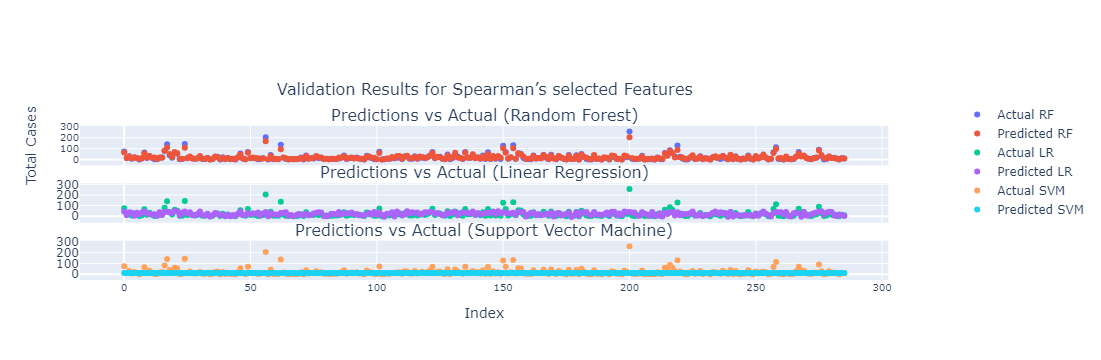

In [48]:
import plotly.figure_factory as ff
fig = make_subplots(rows=4, cols=1, subplot_titles=("Validation Results for Spearman’s selected Features",
                                                    "Predictions vs Actual (Random Forest)", 
                                                    "Predictions vs Actual (Linear Regression)", 
                                                    "Predictions vs Actual (Support Vector Machine)"),
                    vertical_spacing=0.1,
                    row_heights=[0.2, 1, 1, 1],
                    print_grid=False,
                    shared_xaxes=True,
                    specs=[[{"secondary_y": True}], [{"secondary_y": True}], [{"secondary_y": True}], [{"secondary_y": True}]])

# Create a DataFrame for predicted and actual values
predicted_rf_df = pd.DataFrame({'Index': range(len(rf_predictions_df)),
                             'Predicted': rf_predictions_df['total_cases_predicted'],
                             'Actual': y_val})

predicted_lr_df = pd.DataFrame({'Index': range(len(lr_predictions_df)),
                                'Actual': y_val,
                                'Predicted': lr_predictions_df['total_cases_predicted']
                               })
predicted_svm_df = pd.DataFrame({'Index': range(len(lr_predictions_df)),
                                'Actual': y_val,
                                'Predicted': svm_predictions_df['total_cases_predicted']
                               })

# Add scatter plots to the subplots
fig.add_trace(go.Scatter(x=predicted_rf_df['Index'], y=predicted_rf_df['Actual'], mode='markers', name='Actual RF'), row=2, col=1)
fig.add_trace(go.Scatter(x=predicted_rf_df['Index'], y=predicted_rf_df['Predicted'], mode='markers', name='Predicted RF'), row=2, col=1)


fig.add_trace(go.Scatter(x=predicted_lr_df['Index'], y=predicted_lr_df['Actual'], mode='markers', name='Actual LR'), row=3, col=1, secondary_y=False)
fig.add_trace(go.Scatter(x=predicted_lr_df['Index'], y=predicted_lr_df['Predicted'], mode='markers', name='Predicted LR'), row=3, col=1, secondary_y=False)

fig.add_trace(go.Scatter(x=predicted_svm_df['Index'], y=predicted_svm_df['Actual'], mode='markers', name='Actual SVM'), row=4, col=1, secondary_y=False)
fig.add_trace(go.Scatter(x=predicted_svm_df['Index'], y=predicted_svm_df['Predicted'], mode='markers', name='Predicted SVM'), row=4, col=1, secondary_y=False)

# Update layout
fig.update_xaxes(title_text="Index", row=4, col=1, tickfont=dict(size=10))
fig.update_yaxes(title_text="Total Cases", row=2, col=1, tickfont=dict(size=10))

# Show plot
fig.show()

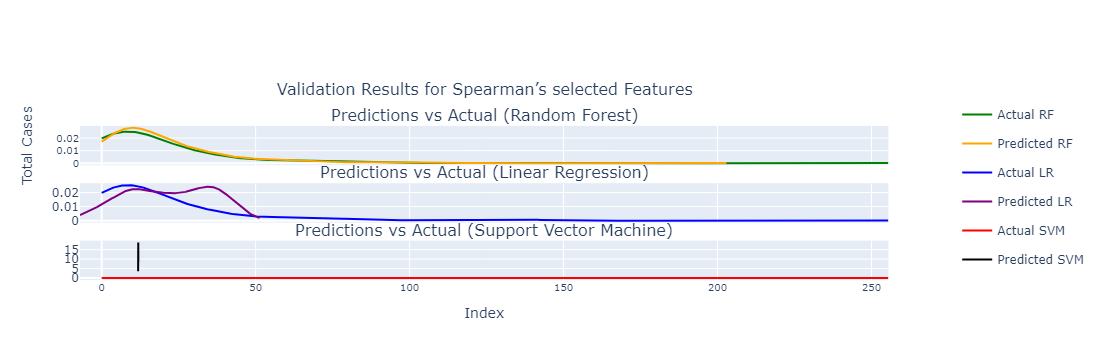

In [49]:
fig = make_subplots(rows=4, cols=1, subplot_titles=("Validation Results for Spearman’s selected Features",
                                                    "Predictions vs Actual (Random Forest)", 
                                                    "Predictions vs Actual (Linear Regression)", 
                                                    "Predictions vs Actual (Support Vector Machine)"),
                    vertical_spacing=0.1,
                    row_heights=[0.2, 1, 1, 1],
                    print_grid=False,
                    shared_xaxes=True,
                    specs=[[{"secondary_y": True}], [{"secondary_y": True}], [{"secondary_y": True}], [{"secondary_y": True}]])

# Add KDE plots to the subplots for Random Forest predictions
kde_rf_actual = ff.create_distplot([predicted_rf_df['Actual']], ['Actual RF'], show_hist=False, colors=['green'])
kde_rf_predicted = ff.create_distplot([predicted_rf_df['Predicted']], ['Predicted RF'], show_hist=False, colors=['orange'])

# Add KDE plots to the subplots for Linear Regression predictions
kde_lr_actual = ff.create_distplot([predicted_lr_df['Actual']], ['Actual LR'], show_hist=False, colors=['blue'])
kde_lr_predicted = ff.create_distplot([predicted_lr_df['Predicted']], ['Predicted LR'], show_hist=False, colors=['purple'])

# Add KDE plots to the subplots for Support Vector Machine predictions
kde_svm_actual = ff.create_distplot([predicted_svm_df['Actual']], ['Actual SVM'], show_hist=False, colors=['red'])
kde_svm_predicted = ff.create_distplot([predicted_svm_df['Predicted']], ['Predicted SVM'], show_hist=False, colors=['black'])

# Add KDE plots to the subplots
fig.add_trace(kde_rf_actual['data'][0], row=2, col=1)
fig.add_trace(kde_rf_predicted['data'][0], row=2, col=1)

fig.add_trace(kde_lr_actual['data'][0], row=3, col=1)
fig.add_trace(kde_lr_predicted['data'][0], row=3, col=1)

fig.add_trace(kde_svm_actual['data'][0], row=4, col=1)
fig.add_trace(kde_svm_predicted['data'][0], row=4, col=1)

# Update layout
fig.update_xaxes(title_text="Index", row=4, col=1, tickfont=dict(size=10))
fig.update_yaxes(title_text="Total Cases", row=2, col=1, tickfont=dict(size=10))

# Show plot
fig.show()

In [50]:
# Selecting top features for each model
top_features_rf = ['year', 'weekofyear', 'reanalysis_air_temp_k',
                  'reanalysis_min_air_temp_k', 'reanalysis_dew_point_temp_k',
                  'reanalysis_max_air_temp_k', 'station_precip_mm',
                  'station_avg_temp_c', 'ndvi_ne', 'reanalysis_specific_humidity_g_per_kg']

top_features_lr = ['reanalysis_specific_humidity_g_per_kg', 'reanalysis_dew_point_temp_k',
                  'ndvi_ne', 'ndvi_sw', 'ndvi_se', 'reanalysis_avg_temp_k', 'ndvi_nw',
                  'reanalysis_tdtr_k', 'reanalysis_relative_humidity_percent',
                  'reanalysis_min_air_temp_k']

top_features_svm = ['station_precip_mm', 'precipitation_amt_mm', 'reanalysis_sat_precip_amt_mm',
                   'weekofyear', 'year', 'reanalysis_relative_humidity_percent', 'reanalysis_tdtr_k',
                   'reanalysis_precip_amt_kg_per_m2', 'reanalysis_min_air_temp_k',
                   'reanalysis_max_air_temp_k']

# Selecting corresponding features from the training and validation datasets
X_train_rf = X_train[top_features_rf]
X_val_rf = X_val[top_features_rf]

X_train_lr = X_train[top_features_lr]
X_val_lr = X_val[top_features_lr]

X_train_svm = X_train[top_features_svm]
X_val_svm = X_val[top_features_svm]

# Initialize models
random_forest_model = RandomForestRegressor(n_estimators=100, random_state=42)
linear_regression_model = LinearRegression()
svm_model = SVR()

# Train Random Forest model
random_forest_model.fit(X_train_rf, y_train)

# Train Linear Regression model
linear_regression_model.fit(X_train_lr, y_train)

# Train Support Vector Machine (SVM) model
svm_model.fit(X_train_svm, y_train)

SVR()

In [51]:
# Make predictions on the validation dataset
predictions_rf = random_forest_model.predict(X_val_rf)
predictions_lr = linear_regression_model.predict(X_val_lr)
predictions_svm = svm_model.predict(X_val_svm)

# Calculate MAE for each model
mae_rf = mean_absolute_error(y_val, predictions_rf)
mae_lr = mean_absolute_error(y_val, predictions_lr)
mae_svm = mean_absolute_error(y_val, predictions_svm)


In [52]:
print(f"Mean Absolute Error for Random Forest: {mae_rf:.2f}")
print(f"Mean Absolute Error for Linear Regression: {mae_lr:.2f}")
print(f"Mean Absolute Error for Support Vector Machine: {mae_svm:.2f}")

# Calculate RMSE for each model
rmse_rf = np.sqrt(mean_squared_error(y_val, predictions_rf))
rmse_lr = np.sqrt(mean_squared_error(y_val, predictions_lr))
rmse_svm = np.sqrt(mean_squared_error(y_val, predictions_svm))

print(f"Root Mean Squared Error for Random Forest: {rmse_rf:.2f}")
print(f"Root Mean Squared Error for Linear Regression: {rmse_lr:.2f}")
print(f"Root Mean Squared Error for Support Vector Machine: {rmse_svm:.2f}")

Mean Absolute Error for Random Forest: 9.94
Mean Absolute Error for Linear Regression: 17.21
Mean Absolute Error for Support Vector Machine: 16.38
Root Mean Squared Error for Random Forest: 18.75
Root Mean Squared Error for Linear Regression: 27.90
Root Mean Squared Error for Support Vector Machine: 32.06


In summary, while our study provides valuable insights into dengue fever prediction, there's scope for improvement and exploration of new methodologies. Addressing limitations and embracing innovative approaches can contribute to more accurate and actionable predictions in disease epidemiology.